# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
from src.featlin import linearization_plots
from src.featlin import generate_target_values

from src.helper import optimise_pls_cv
from src.helper import optimize_regcoef_mape
from src.helper import optimize_regcoef_dist
from sklearn.metrics import mean_absolute_percentage_error

import src.basis as basis

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1
# 

# Previously I used, but not good for colorblind people.
# cmap = sns.color_palette("icefire", as_cmap=True)
# colors = [
#    '#00429d', '#1649a0', '#2351a4', '#2d58a7', 
#    '#3660ab', '#3e67ae', '#456fb2', '#4d77b5', 
#    '#547fb8', '#5b87bb', '#618fbf', '#6896c2', 
#    '#6f9ec5', '#77a6c8', '#7eafcb', '#85b7ce', 
#    '#8dbfd1', '#95c7d3', '#9ecfd6', '#a7d7d8', 
#    '#b1dfdb', '#bbe6dd', '#c7eedf', '#d4f5e0', 
#    '#e5fbe1', '#ffffe0'] 

# colors = ['#332bb3', '#3936b9', '#423fbd', '#4e47bf', '#5b4dbf', '#6953be', '#7657bb', '#845cb7', '#915fb2', '#9e63ad', '#aa66a6', '#b56a9f', '#c06e97', '#ca738f', '#d37887', '#dc7e7e', '#e48575', '#eb8d6d', '#f19764', '#f7a25b']
colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
# colors = ['#00006a', '#280a76', '#411681', '#561f8b', '#692893', '#7c3099', '#8d379f', '#9e3ea2', '#ad46a5', '#bc4ea6', '#c956a6', '#d560a6', '#e06aa4', '#ea76a1', '#f2839d', '#f99299', '#fea393', '#ffb58d', '#ffc985', '#ffdf7b']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = ['#0051a2', '#97964a', '#f4777f', '#93003a']
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]

marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

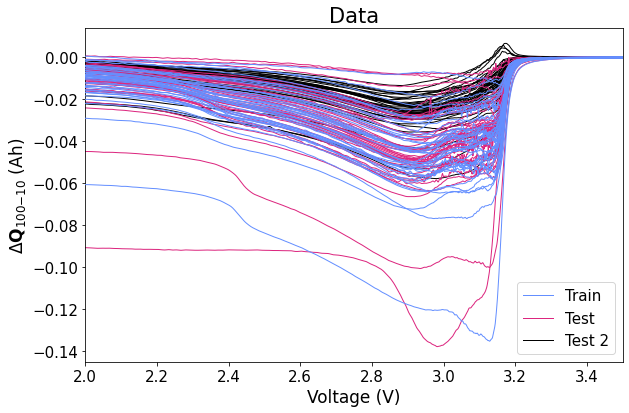

In [5]:
# Make Dataset Plots. 
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_train, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], zorder=3)
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_test, colors_IBM[2], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test', zorder=2)
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_test2, colors_IBM[5], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test 2', zorder=1)
ax.set_title('Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'data.pdf')

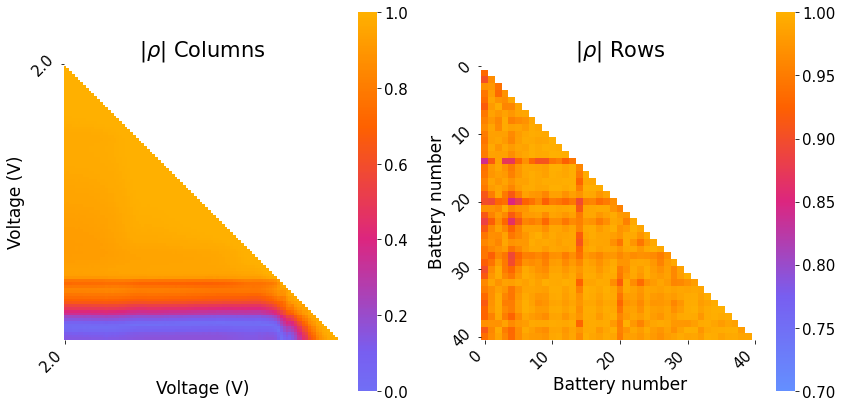

In [6]:
# Correlations: 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0] = src.featlin.plot_corrheatmap(axs[0], x_lfp, X_lfp_train, cmap, labels_lfp['xdata_label'], labels_lfp['xdata_label'], r'$|\rho|$ Columns')
axs[1] = src.featlin.plot_corrheatmap(axs[1], np.arange(X_lfp_train.T.shape[1]), X_lfp_train.T, cmap, labels_lfp['row_label'], labels_lfp['row_label'], r'$|\rho|$ Rows', cols=False)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'corr.pdf')

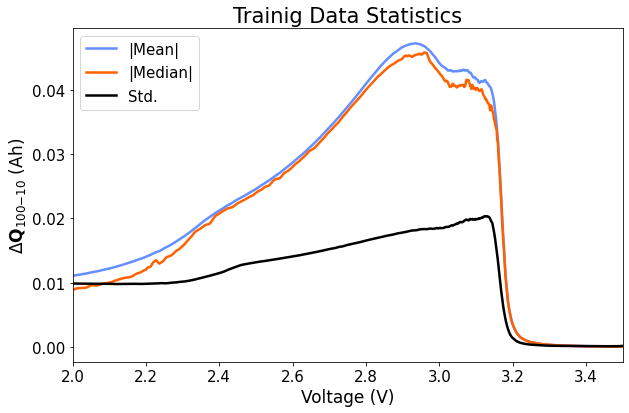

In [7]:
# Data Stats
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_stats(ax, x_lfp, X_lfp_train, colors_IBM[0], colors_IBM[5], colors_IBM[3], labels_lfp['xdata_label'], labels_lfp['ydata_label'])
ax.set_title('Trainig Data Statistics')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'stats.pdf')
plt.show()

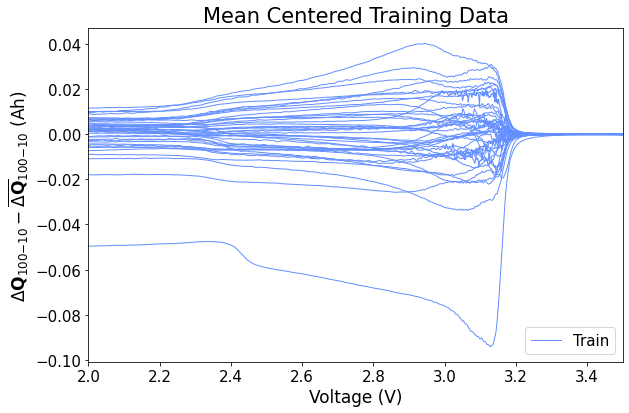

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_lfp_train-np.mean(X_lfp_train, axis=0), colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'$\Delta \mathbf{Q}_{100\mathrm{-}10} - \overline{\Delta \mathbf{Q}}_{100\mathrm{-}10}$ (Ah)')
ax.set_title('Mean Centered Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'mctrain.pdf')
plt.show()

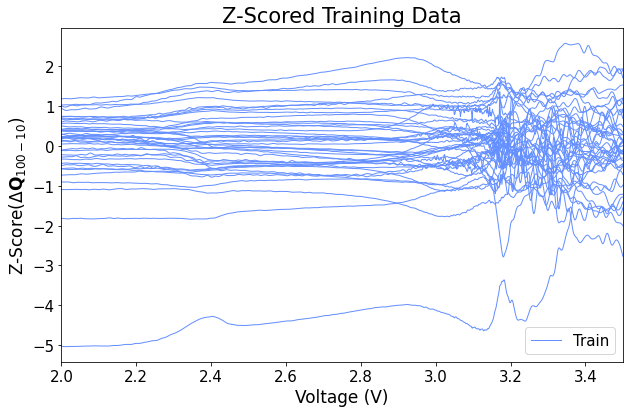

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_zscore = scaler.fit_transform(X_lfp_train)

fig, ax = plt.subplots(figsize=(9,6))
ax = src.featlin.plot_x_tt2(ax, x_lfp, X_zscore, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'Z-Score$(\Delta \mathbf{Q}_{100-10})$')
ax.set_title('Z-Scored Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'zscoretrain.pdf')
plt.show()

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [10]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
    #lambda a : jnp.sum(jnp.sqrt(a))

# Transform the jax array types to numpy arrays.
fun_target = [lambda a: np.array(fun_targetj[i](a)) for i in range(len(fun_targetj))]

fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]
X = X_lfp_train-np.mean(X_lfp, axis=0)
y_gt = np.zeros([X.shape[0], 5, 1])
for j in range(len(fun_targetj)): 
    y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [24]:
def anlyse_features(
    X, x_lfp, y, fun_targetj, color_dict, 
    cv=1, include_cv_model=0, opt_mape=0, opt_dist=1, norm=1, 
    scatter=0, plot_cv=0, verbose=1, include_min_dist_model=1, max_mape=-0.5):
    ''' Function to anlayse features given certain data! (: '''

    from src.featlin import linearization_regeression_row_plots
    # PLS 1 model is always selected as a reference. 
    # Models
    models = [
        # PLSRegression(n_components=1, tol=1e-7, scale=False)
    ]
    model_names = [
        # 'PLS 1 comp'
    ]

    # Calculate the feature and linearized coef.
    x_hat, lin_coef_, lin_const_coef = regress_linearized_coeff(X, y, fun_targetj)


    if scatter:
        # Make a scatterpliot here, to see whats going on.
        # Where do you linearize? The more nonlinear the more outlier, the crappier this mehtod will be!
        # Whats the path regression coefficeints take with varying regularization?
        plt.scatter(X@lin_coef_.reshape(-1), y_gt[:, 1])
        plt.scatter(np.array([fun_targetj[1](X[i, :]) for i in range(X.shape[0])]), y_gt[:, 1])
        lin_sp = np.linspace(np.min(y_gt[:, 1]), np.max(y_gt[:, 1]), 10)
        plt.plot(lin_sp, lin_sp)

    # CV only for PLS!
    if cv:
        cv_dict = optimise_pls_cv(
            X, y, max_comps=10, plot_components=plot_cv, std=False, min_distance_search=True, featlin=lin_coef_)
        rmse_min_comp = cv_dict['components'][cv_dict['rmse_std_min']]
        if include_cv_model:
            models.append(PLSRegression(n_components=rmse_min_comp, tol=1e-7, scale=False),)
            model_names.append('PLS ' + str(rmse_min_comp) + ' comp')

    if opt_mape:
        mape_lin = 100*mean_absolute_percentage_error(y, X@lin_coef_.reshape(-1))
        alpha = optimize_regcoef_mape('ridge', X, y, [10**5, 10**(-5)], mape_lin+1.5, max_depth=10)
        models.append(Ridge(alpha=alpha))
        model_names.append(f" RR: {alpha:.2f}")

    if opt_dist:
        alpha = optimize_regcoef_dist('ridge', X, y, [10**5, 10**(-5)], lin_coef_, norm=1, max_depth=10)
        # models.append(Ridge(alpha=alpha))
        # model_names.append(f" RR: {alpha:.2f}")

        comp = optimize_regcoef_dist('PLS', X, y, [10], lin_coef_, norm=1, max_depth=10)

        # Ensures that this is the last list item by removing previous identical entries. 
        if f"PLS {comp} comp" in model_names:
            id = model_names.index(f"PLS {comp} comp")
            model_names.remove(f"PLS {comp} comp")
            print(id)
            models.pop(id)
            # models.remove(PLSRegression(n_components=comp, tol=1e-7, scale=False))
        if include_min_dist_model:
            models.append(PLSRegression(n_components=comp, tol=1e-7, scale=False))
            model_names.append(f"PLS {comp} comp")
                
    
    model_dict = {'models': models, 'model_names': model_names}
    label_dict = {'xlabel': 'Voltage (V)'}

    fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [7, 3, 3]}, figsize=(36,7))
    linearization_regeression_row_plots(
        X, x_lfp, y, fun_targetj, axs, cmap, model_dict, color_dict, label_dict,
        nullspace_corr=True, plot_nullspace_bool=False, max_mape=max_mape)
    plt.show()

    return 

close to $\mathcal{\mathbf{N}}(X) xyz$


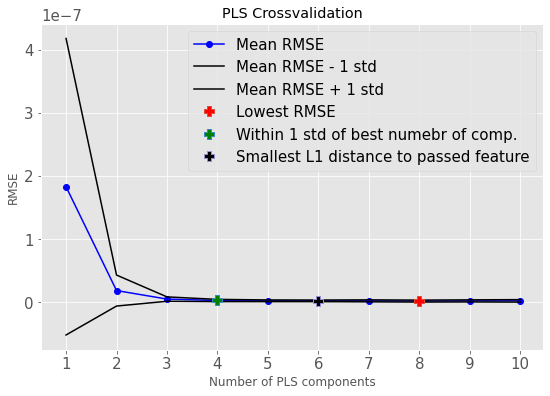

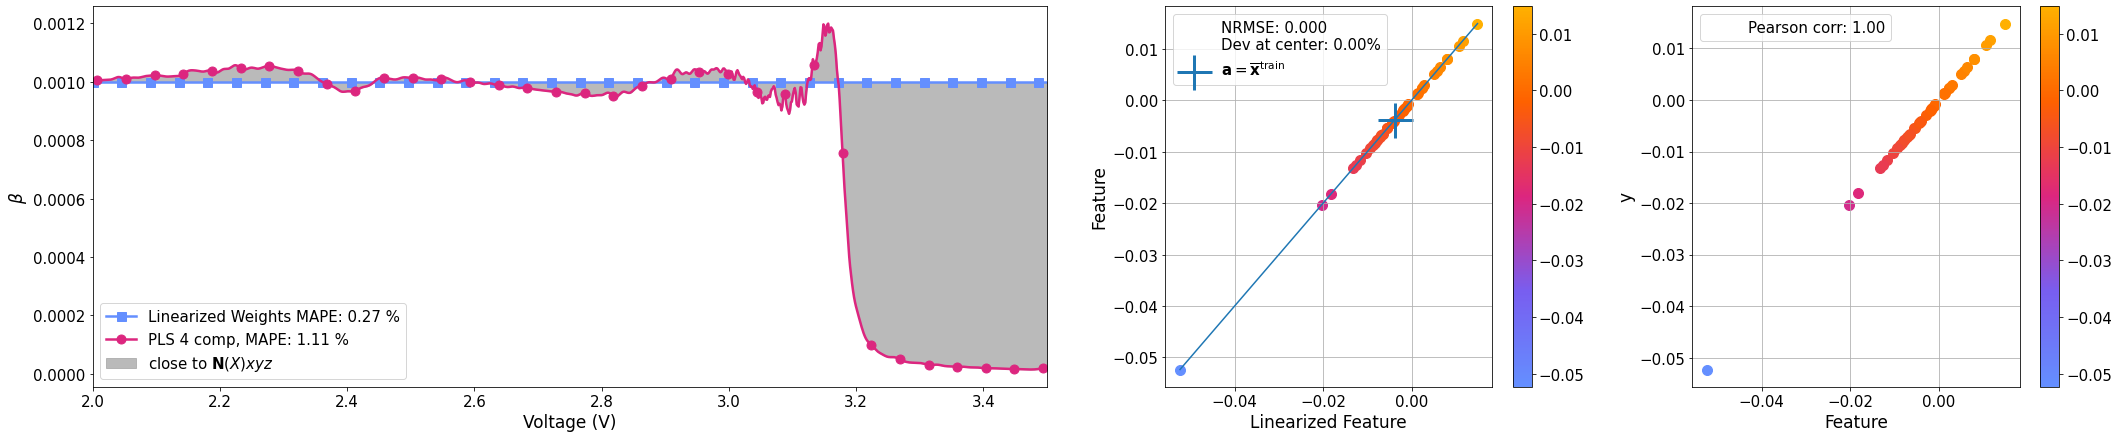

In [25]:
# Now fix the gamma value
# Make 2 plots + list of \gamma values telling the user how much deviation from the nullspace is necessary. 
# Then move on to the more complicated examples.
# Fix the standard deviation rule, this should help to avoid the nasty area.

# Note that because we use a linear feature we use the crossvalidated 1std rule to determine the feature.
# IF the feature would be nonlinear, we should be more conservative and use the min_dist_model. 
# The reason therefore is that PLS and other regression models must try to linearly capture nonlinearity. 
# This often results in more spicky regression coefficients that are expected to deviate from the linearized coefficients.

color_dict = {'color_list': color_list, 'marker_list': marker_list}
anlyse_features(
    X, x_lfp, y_gt[:, 0], fun_targetj[0], color_dict, color_dict, plot_cv=True, 
    include_cv_model=1, include_min_dist_model=0, max_mape=1)
plt.show()

Gamma value corresponding to MAPE=1.00 % is 125.63925844917607
close to $\mathcal{\mathbf{N}}(X) xyz$


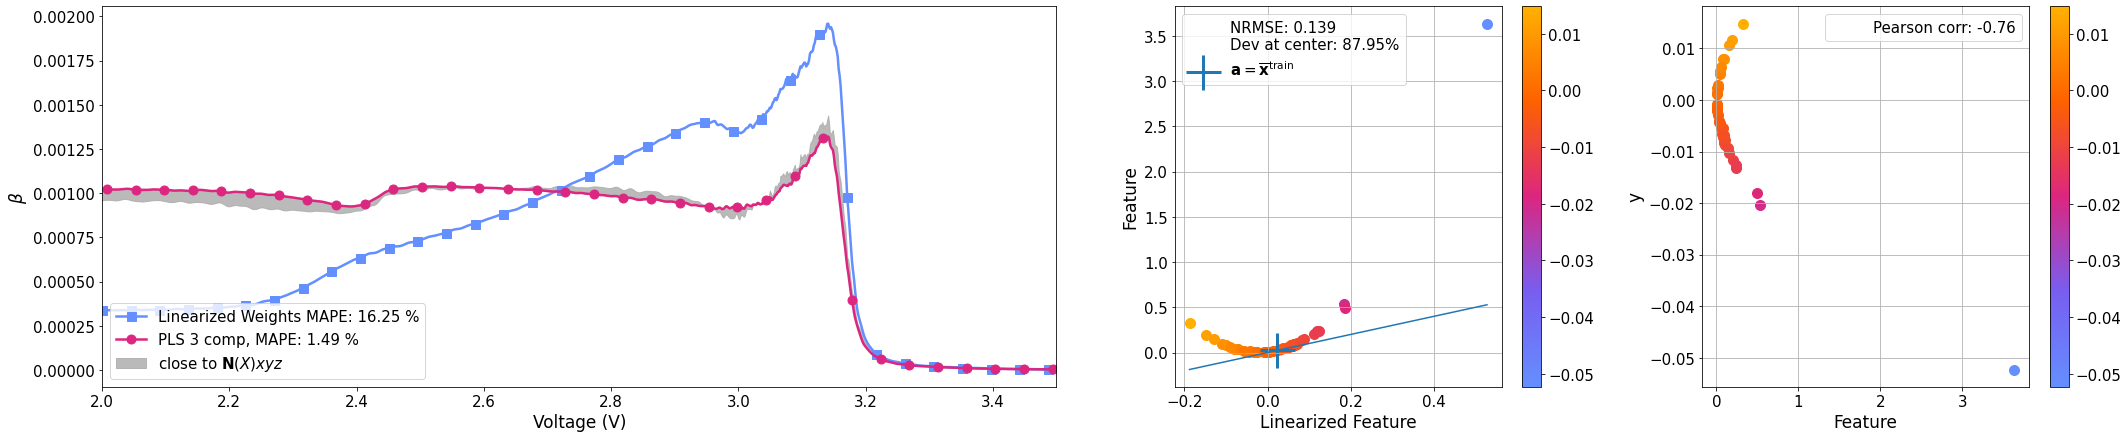

In [26]:
anlyse_features(X, x_lfp, y_gt[:, 0], fun_targetj[1], color_dict, color_dict, plot_cv=0, max_mape=1)

1.2430509708709188
1
0


KeyboardInterrupt: 

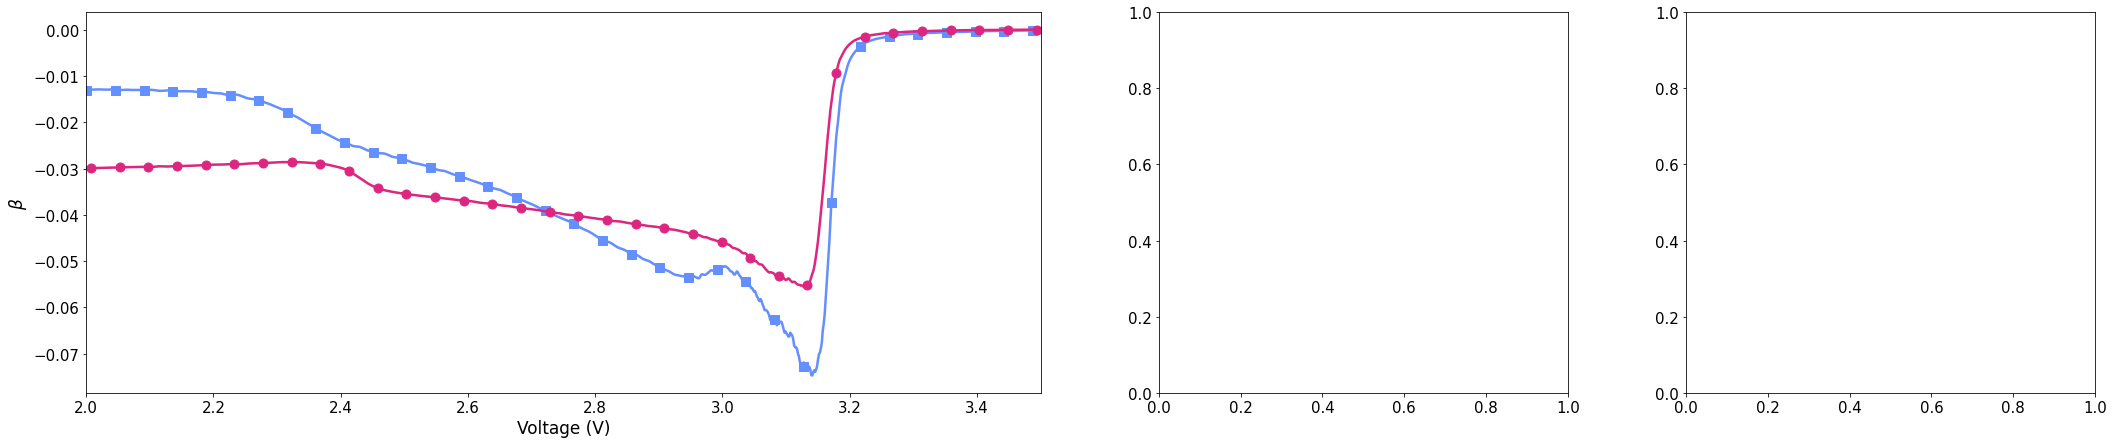

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 1], fun_targetj[1], color_dict, color_dict)

0.9367679133390746
1
0
Gamma value corresponding to MAPE=11.15 % is 52.494840206815944
[49.08650365 49.55951303 50.03708045 50.51924982 51.0060655  51.49757224
 51.99381527 52.49484021]
close to $\mathcal{\mathbf{N}}(X) xyz$


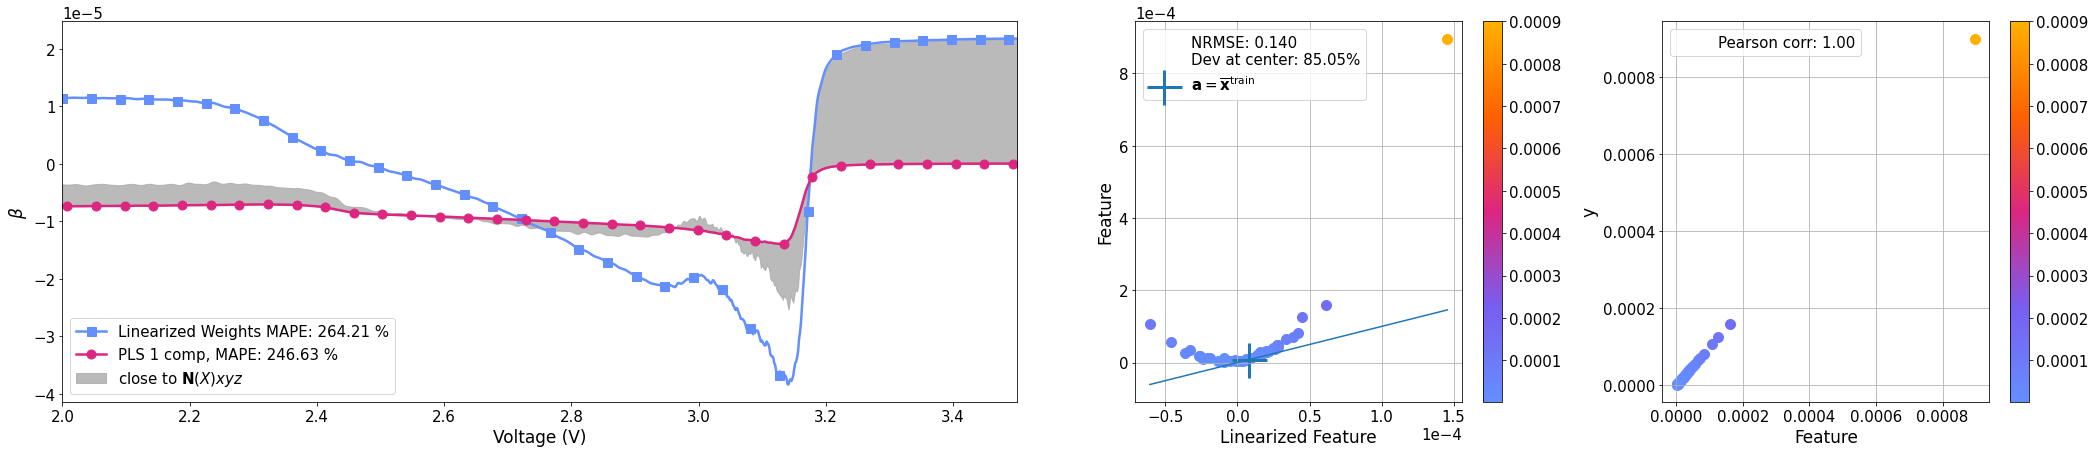

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 2], fun_targetj[2], color_dict, color_dict)

0.20076551593773906
1
0


KeyboardInterrupt: 

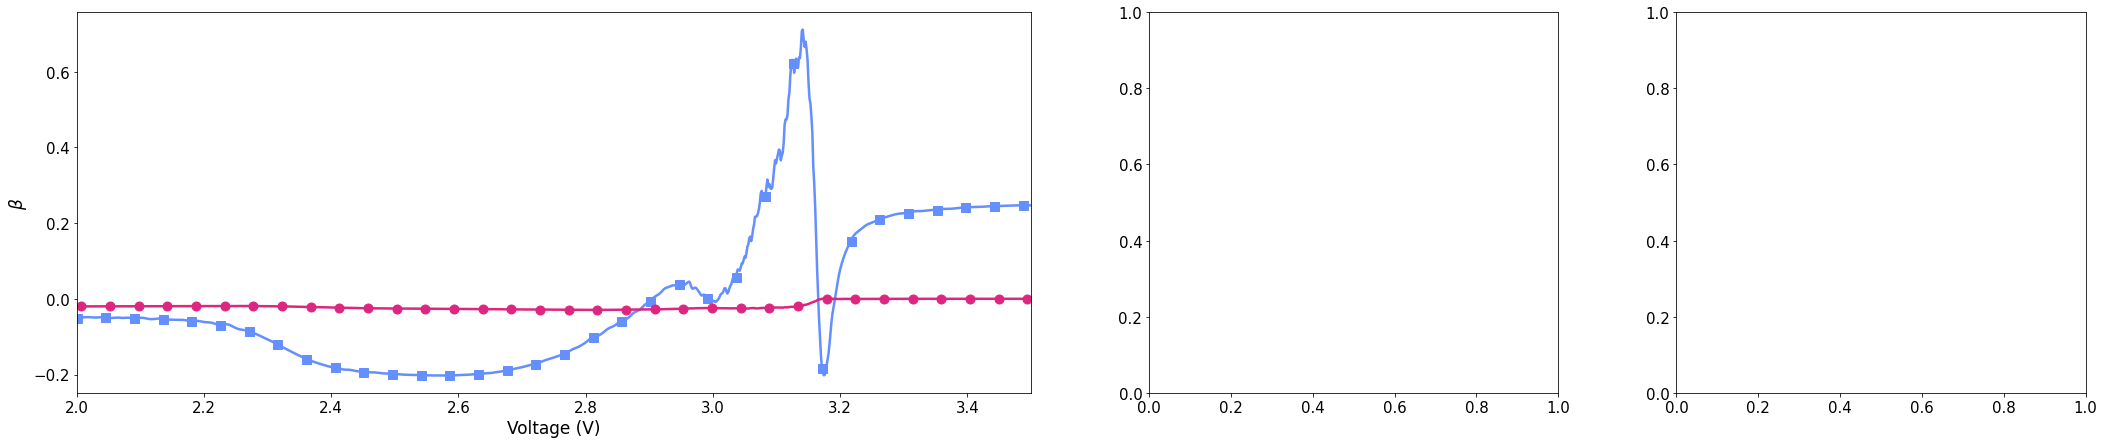

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 3], fun_targetj[3], color_dict, color_dict)

0.16008106463246974
1
0
Gamma value corresponding to MAPE=2.47 % is 117.48186858201902


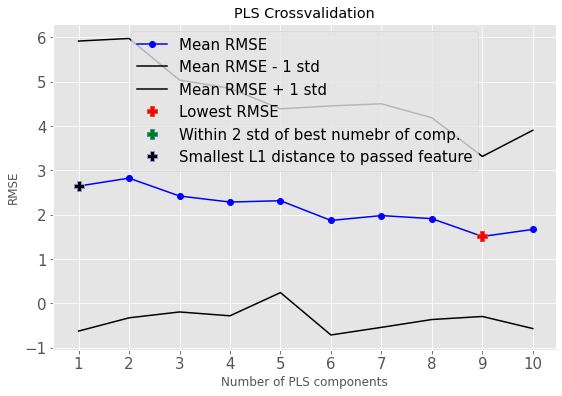

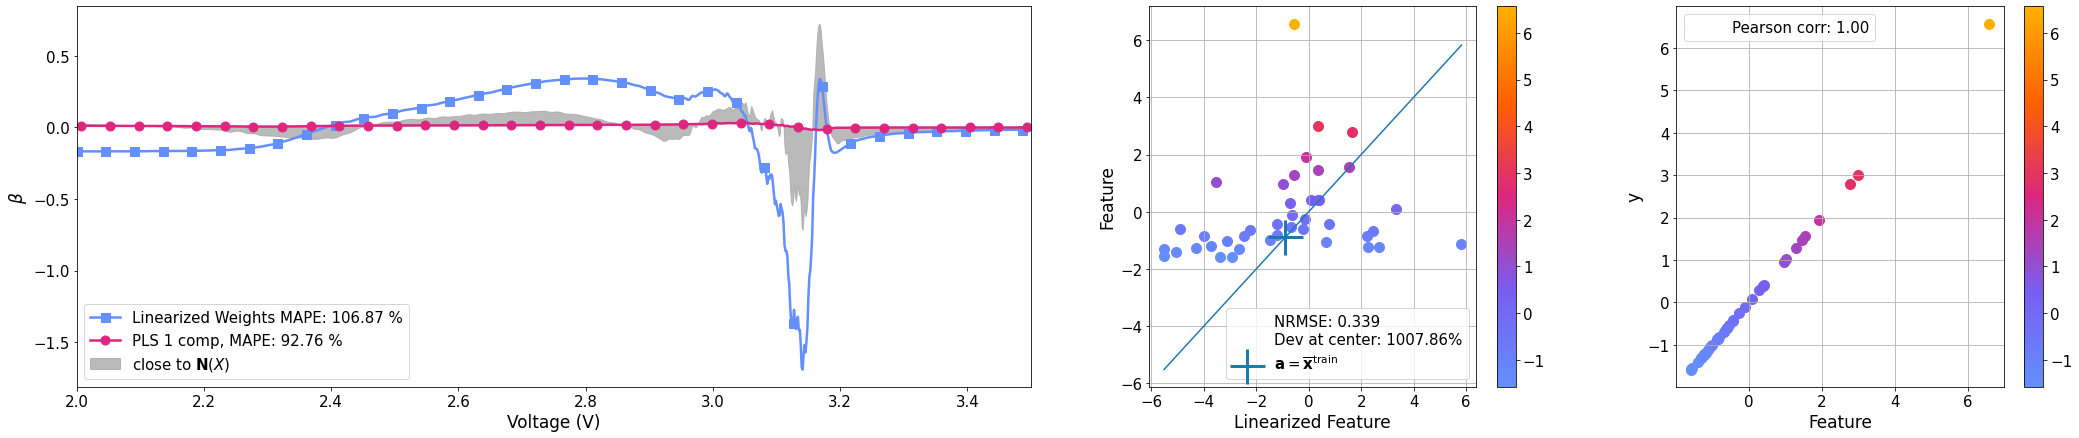

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 4], fun_targetj[4], color_dict, color_dict)

# Large Map of Results

Gamma value corresponding to MAPE=3.76 % is 3.5804355457805945
Gamma value corresponding to MAPE=56.21 % is 9.800622114914782
Gamma value corresponding to MAPE=47.94 % is 17.932643502091338
Gamma value corresponding to MAPE=5.70 % is 9.800622114914782
Gamma value corresponding to MAPE=0.65 % is 672.9585855529835


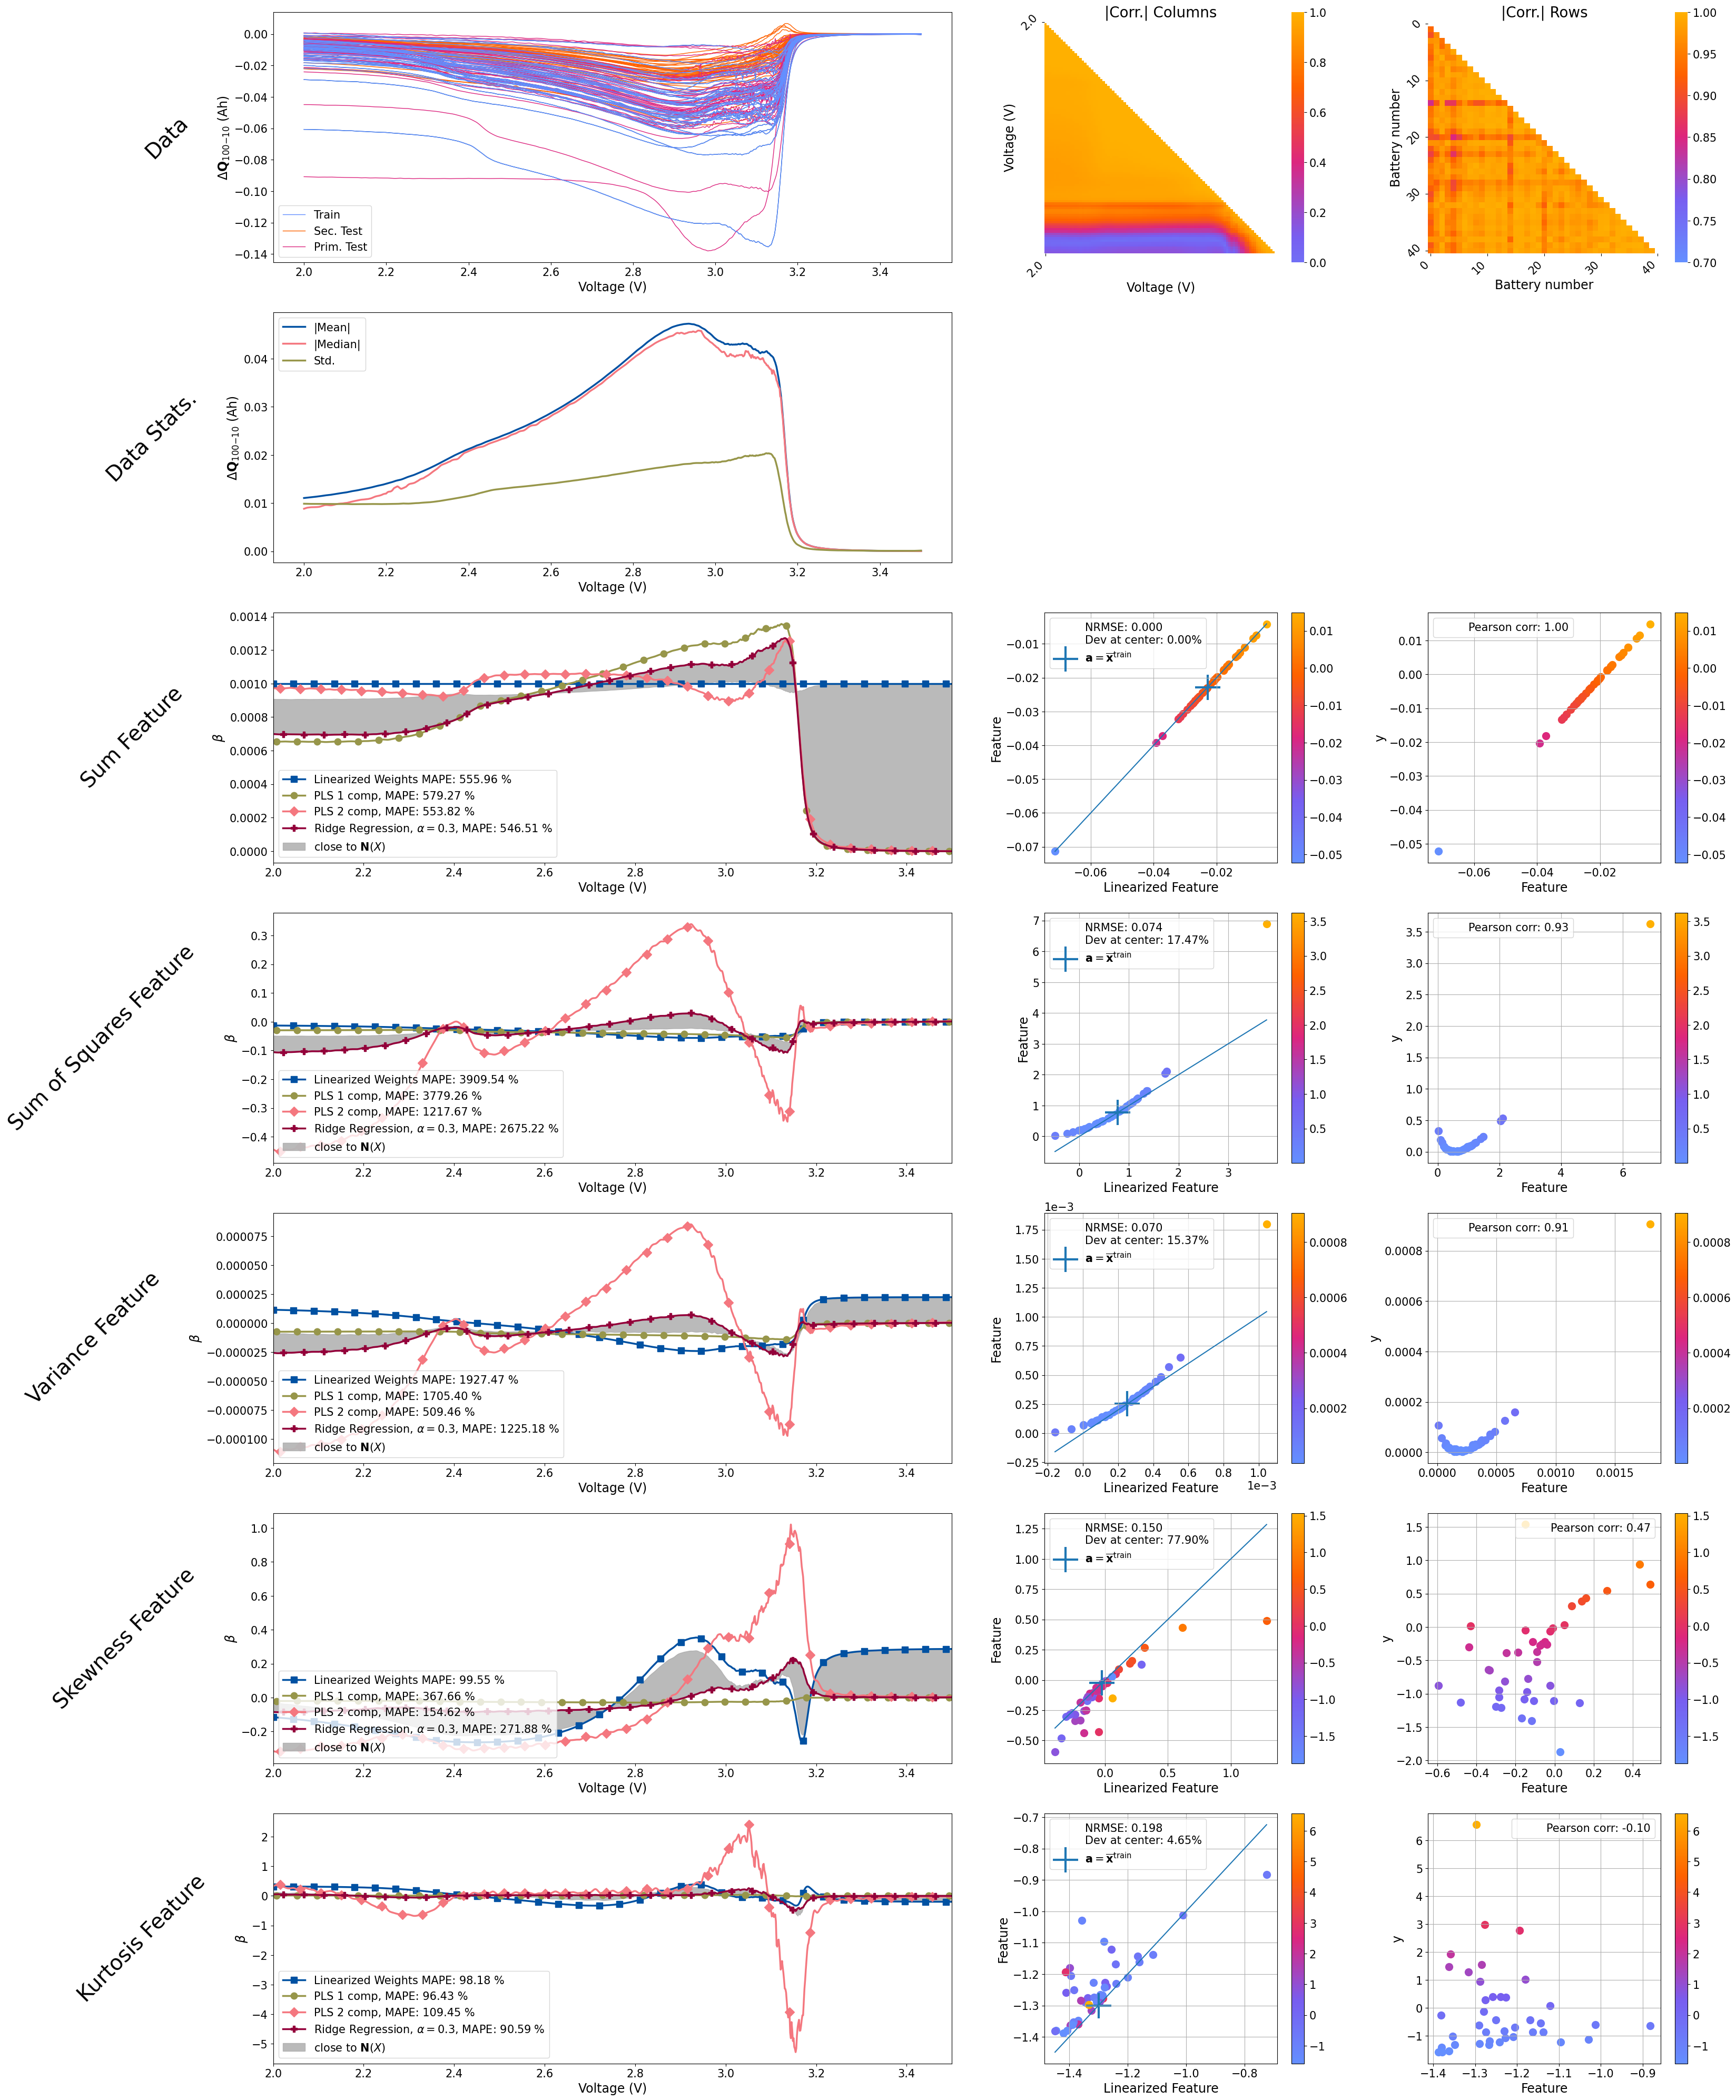

In [ ]:
from importlib import reload
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    # PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    # 'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_gt, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

# Plot Test, Test 2 into axs[0, 0]\
axs[0, 0].plot(x_lfp, X_lfp_test2[:, :].T, label='Sec. Test', lw=1, color=color_list[2])
axs[0, 0].plot(x_lfp, X_lfp_test[:, :].T, label='Prim. Test', lw=1, color=color_list[1])
axs[0, 0].plot(x_lfp, X_lfp_train[:, :].T, label='Train', lw=1, color=color_list[0])
handles, labels = axs[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0, 0].legend(by_label.values(), by_label.keys(), loc=3)

plt.show()

# RDB What would be useful in your opinoin?
# Insert additional plots for  axs[1, 1] and axs[1, 2] in here. 
# Correlation of each column to y
# Train and test dataset correlations ( one plot per test)


In [ ]:
def reject_outliers(data, m = 2.):
    '''
    https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    Answer from Benjamin Bannier
    '''
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m], s<m

In [ ]:
d = {'ashfkjlrg':1, 'bgadsrjklr':2}

In [ ]:
d.keys()

dict_keys(['ashfkjlrg', 'bgadsrjklr'])

In [ ]:
# Now without the outlier's (; 
X_lfp_train_filtered_mean, ind =  reject_outliers(np.mean(X_lfp_train, axis=1), m = 2.5)


models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    PLSRegression(n_components=3, tol=1e-7, scale=False), 
    #Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    'PLS 3 comp',
    #r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train[ind, :], y_lfp_train[ind, :], fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

NameError: name 'y_lfp_train' is not defined

In [ ]:
# LFP with real labels (:
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    # PLSRegression(n_components=2, tol=1e-7, scale=False),
    #PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    # 'PLS 2 comp',
    #'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_lfp_train_true, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

In [ ]:
def plot_axs(x,  X_train_, X_test_, y_train_, fun_targetj, alpha):
    ''' Function to create plot of data and regression coefficients
    '''
    colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
    rows = len(fun_targetj) + 2
    columns = X_train_.shape[2]+1
    figsize = [10*columns, 6*rows]

    fig, axs = plt.subplots(rows, columns, figsize=figsize, sharex=True)

    axs[0, 0].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 0].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    axs[0, 1].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 1].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 1].plot(x, X_train_[:, :, 1].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 1].plot(x, X_test_[:, :, 1].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 2].plot(x, X_train_[:, :, 2].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 2].plot(x, X_test_[:, :, 2].T, label='Test Data', lw=1, color=colors[1])
    axs[1, 0].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 0].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 1].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 1].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 0].legend()
    axs[1, 1].legend()
    
    for i in range(X_train_.shape[2]):
        handles, labels = axs[0, i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[0, i].legend(by_label.values(), by_label.keys(), loc=2, fontsize=22)

    for i in range(X_train_.shape[2]):
        for j in range(y_train_.shape[1]):
            X_train = X_train_[:, :, i]
            y_train = y_train_[:, j, i]
            pls1 = PLSRegression(n_components=1, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls2 = PLSRegression(n_components=2, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls3 = PLSRegression(n_components=3, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls4 = PLSRegression(n_components=4, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            rr = Ridge(alpha=alpha).fit(X_train, y_train-y_train.mean())

            x_hat, lin_coef_, lin_const_coef = regress_linearized_coeff(X_train, y_train, fun_targetj[j])
            axs[j+2, i].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i+1].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i].plot(x, pls1.coef_, label=r'$\beta_{PLS}$, 1 Component', lw=2.5, color=colors[1], marker="o", markevery=(10, 30), markersize=9)
            axs[j+2, i].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls3.coef_, label=r'$\beta_{PLS}$, 3 Component', lw=2.5, color=colors[3], marker="D", markevery=(20, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls4.coef_, label=r'$\beta_{PLS}$, 4 Component', lw=2.5, color=colors[1], marker="D", markevery=(25, 30), markersize=9)
            axs[j+2, i].plot(x, rr.coef_, label=r'$\beta_{RR}$  $\lambda=0.5$', lw=2.5, color=colors[3], marker="P", markevery=(20, 30),  markersize=9)
            
            # axs.grid()
            handles1, labels1 = axs[j+1, i].get_legend_handles_labels()
            by_label1 = dict(zip(labels1, handles1))
            handles2, labels2 = axs[j+1, i+1].get_legend_handles_labels()
            by_label2 = dict(zip(labels2, handles2))
            axs[j+2, i].legend(by_label1.values(), by_label1.keys(), loc=2, fontsize=16)
            axs[j+2, i+1].legend(by_label2.values(), by_label2.keys(), loc=2, fontsize=16)
            
            axs[j+2, i].set_title(fun_target_names[j])
            axs[j+2, i+1].set_title(fun_target_names[j])

    plt.tight_layout()
    plt.show()
            
    return None

In [ ]:
# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact, fixed

scaler = preprocessing.StandardScaler().fit(X_lfp_train)
X_scaled = scaler.transform(X_lfp_train)
interact(plot_axs, x=fixed(np.linspace(3.5, 2.0, 1000)),  X_train_=fixed(np.expand_dims(X_lfp_train, axis=2)), 
        X_test_=fixed(np.expand_dims(X_lfp_test, axis=2)), y_train_=fixed(y_lfp_train), fun_targetj=fixed(fun_targetj),
        alpha=ipywidgets.FloatLogSlider(value = 0.5,
                                    base = 2,
                                    min=-10, 
                                    max=10, 
                                    step=0.0001, 
                                    description='Alpha RR',
                                    continuous_update=True)
                                    )

In [ ]:
# Why don't the linear methods point into the directions that would be ideal?  
# The effect of 'outliers' ?

# Even in an ideal world this will not work too well. 
# Reasons: 
# 1. Nullspace of the data, 
# 2. The way of regularization will affed the shape of the coefficiencts a lot. 
# IF there's some linear order, the algorithms will always learn coefficients that have a similar shape as the data!
# How much are the algorithms affected by outliers? 
# How much are the algorithms affected by not standardizing the data
# How much does correlation between columns affect the results? 

# --> Conclusion: Interesting new perspective on interpretation of regression coefficients. 
# How do regression coeffcieints compare with standardizartion and without?

# Negative regression coefficients: This is NOT an issue. Might be simply because of the y-y.mean(). 
# How and when does the sign of regression coefficients flip?


# Conclusions: It can give you some directions that might be interesting. 
# HOWEVER: Regression coefficients often look similar to the data... 
# Why is this the case? 
# --> Because the data is not standardized, we apply an implicicit preference larger weights on regions that with a larger mean/std 
# Thsi regiosn might also contiana more information, but deu to the way how regularization is done, if the regions where the magnitude of the data is smaller 
# doesnt carry significatly more information, those will go to zero//they might be eassier to regularize down.

# Common issues with such datasets: 
# Correlation of columns. 

# Hyperparamter: How to find the right hyperparamter?
# PLS with its integer hyperparamters might not be ideal

# Idea: Tune RR hyperparamter to optimize the fit of th regression coefficient with the feature as a measure. 
# (Metric based on the difference of the prediction, or simpoly apply some nullspace trick)

# You can get around the issue of hyperparamter tuning by only using the first 1 or 2 PLS components.

In [ ]:
# Key Questions: 

# 1. Linear examples: Show that it works with CV
# 2. Nonlinear example, show that it wokrs with CV BUT might require nullspace. 
# 3. Was there a big eefect on whether the outlier is included or not? Leave it in if not.
# 3. How to do CV? RR or PLS? IF PLS: Can we just pretune and then finetune? 

# Is CV even the right wauy?
# Conservative estimates might be better/more apporpriate.

# Reworke the Nullspace code. 
# Decide on how it shall be decided. Tolerable MAPE? (this could be stiamted based on the noise that is present in the data, difference between resutls of splits etc.)
